In [1]:
#loading required packages
import re
import numpy as np
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
from better_profanity import profanity
import seaborn
import sklearn
from sklearn.metrics import precision_score,recall_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#reading the dataset
df = pd.read_csv('ebola_tweets.csv')

In [3]:
len(df)

13629

In [4]:
df.drop_duplicates(subset = ["timestamp", "user", "text"], inplace=True)
print(f"all tweets: {df.shape}")

all tweets: (8395, 6)


In [5]:
df.rename(columns={"text": "tweets"}, inplace=True)
df.head()

,timestamp,user,tweets,favorite_count,retweet_count,location
0,2023-01-06 20:52:04+00:00,NorbRomney,RT @nkcsteve55: @GovRonDeSantis Hmm...the Ebol...,0,0,NaN
1,2023-01-06 20:47:54+00:00,hernangraffe,RT @NIAIDNews: EBOLA NEWS: Three #Ebola #vacci...,0,12,Caracas
2,2023-01-06 20:47:19+00:00,mmd362230282,RT @WOAH: Our radio awareness campaign in the ...,0,38,NaN
3,2023-01-06 20:44:52+00:00,OscarSpivitz,@coopsimms @site_alpha To me it was like Ebola...,0,0,NaN
4,2023-01-06 20:42:28+00:00,mayrabella101,I am glad Liesel didn't do anything to Ebola ...,2,0,"New York, New York"


In [6]:
df['tweets'] = df['tweets'].str.replace("going", "lockdown")

In [7]:
# Converting only the tweets into a list
tweet_list = df.tweets.to_list()

In [8]:
# Creating a function to clean the tweets

def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    r = tweet.lower()
    r = profanity.censor(r)
    r = re.sub("'", "", r) # This is to avoid removing contractions in english
    r = re.sub("@[A-Za-z0-9_]+","", r)
    r = re.sub("#[A-Za-z0-9_]+","", r)
    r = re.sub(r'http\S+', '', r)
    r = re.sub('[()!?]', ' ', r)
    r = re.sub('\[.*?\]',' ', r)
    r = re.sub("[^a-z0-9]"," ", r)
    r = re.sub('rt','Mubende',r)
    r = r.split()
    stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from","us"]
    r = [w for w in r if not w in stopwords]
    r = " ".join(word for word in r)
    return r

In [9]:
#cleaning the data
cleaned = [clean_tweet(tw) for tw in tweet_list]

C:\Users\amiru\AppData\Local\Temp\ipykernel_9520\3429386824.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


In [10]:
# Defining the sentiment objects using TextBlob
sentiment_objects = [TextBlob(tweet) for tweet in cleaned]
sentiment_objects[0].polarity, sentiment_objects[0]

(0.375,
 TextBlob("Mubende hmm ebola vaccine is mrna are you familiar with ebola might wanna check that out before trashing e"))

In [36]:
# Creating a list of polarity values and tweet text
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]
#sentiment_values[0]
#sentiment_values[0:99]

In [37]:
# Creating a dataframe of each tweet against its polarity
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])
sentiment_df.head()

,polarity,tweet
0,0.375,Mubende hmm ebola vaccine is mrna are you fami...
1,0.500,Mubende ebola news three regimens shown be saf...
2,0.000,Mubende our radio awareness campaign democrati...
3,-0.400,me it was like ebola hydrogen bomb making baby...
4,0.500,i am glad liesel didnt do anything ebola becau...


In [38]:
sentiment_df['category'] = np.where(sentiment_df['polarity'] > 0, 'Positive', np.where(sentiment_df['polarity'] <0, 'Negative', 'Neutral'))

In [39]:
sentiment_df.head()

,polarity,tweet,category
0,0.375,Mubende hmm ebola vaccine is mrna are you fami...,Positive
1,0.500,Mubende ebola news three regimens shown be saf...,Positive
2,0.000,Mubende our radio awareness campaign democrati...,Neutral
3,-0.400,me it was like ebola hydrogen bomb making baby...,Negative
4,0.500,i am glad liesel didnt do anything ebola becau...,Positive


In [40]:
sentiment_df['category'].value_counts()

Neutral     3690
Positive    2820
Negative    1885
Name: category, dtype: int64

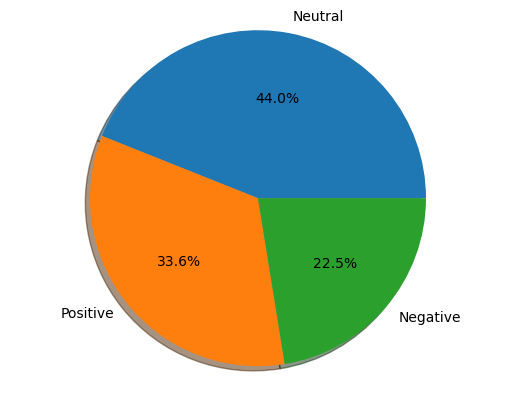

In [41]:
# Counting the number of occurrences of each category
counts = sentiment_df['category'].value_counts()

# Pie Chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.show()

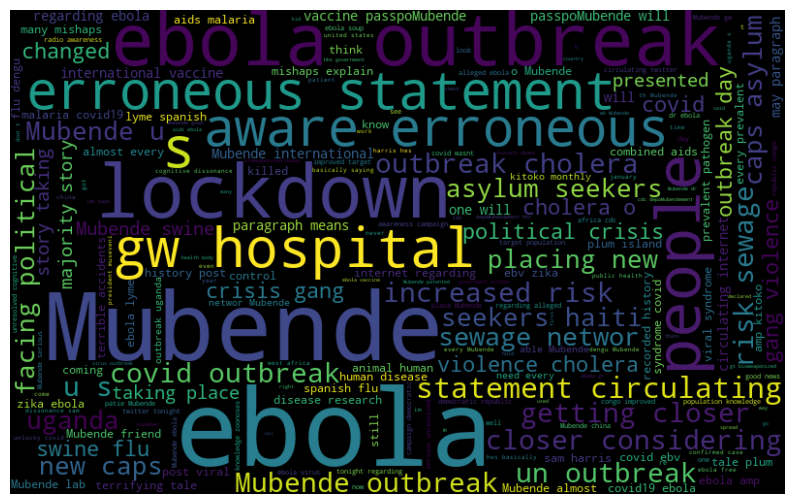

In [42]:
# Creating a Wordcloud from the tweets
from PIL import Image
all_words = ' '.join([text for text in cleaned])
wordcloud = WordCloud(width=800, height=500, random_state=21,  max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
#plt.show()
plt.savefig('cloudword.pdf')

In [43]:
#sentiment scores
mapping = {'Positive':0,'Negative':1,'Neutral':2}
sentiment_df['category'] = sentiment_df['category'].map(mapping)

In [44]:
tokenizer = Tokenizer(num_words=100, oov_token="<OOV>")
tokenizer.fit_on_texts(sentiment_df['tweet'])

sequences = tokenizer.texts_to_sequences(sentiment_df['tweet'])

padded_sequences = pad_sequences(sequences, padding='post', maxlen=None)

labels = sentiment_df['category']

train_data, test_data, train_labels, test_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=0)

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=0)

In [45]:
train_data.shape

(5372, 27)

In [46]:
print(f"Size of the training data: {len(train_data)}")
print(f"Size of the training labels data: {len(train_labels)}")
print(f"Size of the validation data: {len(val_data)}")
print(f"Size of the validation lables data: {len(val_labels)}")
print(f"Size of the testing data: {len(test_data)}")
print(f"Size of the testing labels: {len(test_labels)}")

Size of the training data: 5372
Size of the training labels data: 5372
Size of the validation data: 1344
Size of the validation lables data: 1344
Size of the testing data: 1679
Size of the testing labels: 1679


# CNN model

In [87]:
model = keras.Sequential([
    keras.layers.Embedding(input_dim=100, output_dim=16, input_length=20),
    keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=3, activation='softmax')
])



In [88]:
train_data = pad_sequences(train_data, maxlen=20)
val_data = pad_sequences(val_data, maxlen=20)

# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(train_data, train_labels, epochs=10, verbose=1, batch_size=64, validation_data=(val_data, val_labels))

Epoch 1/10
84/84 [==============================] - 1s 4ms/step - loss: 1.0675 - accuracy: 0.4337 - val_loss: 1.0432 - val_accuracy: 0.4740
Epoch 2/10
84/84 [==============================] - 0s 3ms/step - loss: 1.0020 - accuracy: 0.5158 - val_loss: 0.9054 - val_accuracy: 0.6124
Epoch 3/10
84/84 [==============================] - 0s 2ms/step - loss: 0.8943 - accuracy: 0.5961 - val_loss: 0.8141 - val_accuracy: 0.6384
Epoch 4/10
84/84 [==============================] - 0s 2ms/step - loss: 0.8314 - accuracy: 0.6329 - val_loss: 0.7851 - val_accuracy: 0.6406
Epoch 5/10
84/84 [==============================] - 0s 2ms/step - loss: 0.7896 - accuracy: 0.6556 - val_loss: 0.7603 - val_accuracy: 0.6525
Epoch 6/10
84/84 [==============================] - 0s 2ms/step - loss: 0.7656 - accuracy: 0.6690 - val_loss: 0.7600 - val_accuracy: 0.6637
Epoch 7/10
84/84 [==============================] - 0s 2ms/step - loss: 0.7505 - accuracy: 0.6763 - val_loss: 0.7310 - val_accuracy: 0.6689
Epoch 8/10
84/84 [==

In [89]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 20, 16)            1600      
                                                                 
 conv1d_14 (Conv1D)          (None, 18, 32)            1568      
                                                                 
 conv1d_15 (Conv1D)          (None, 16, 32)            3104      
                                                                 
 global_max_pooling1d_11 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                2112      
                                                      

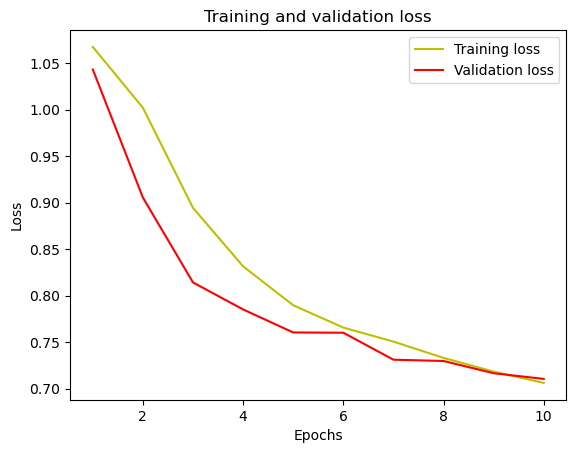

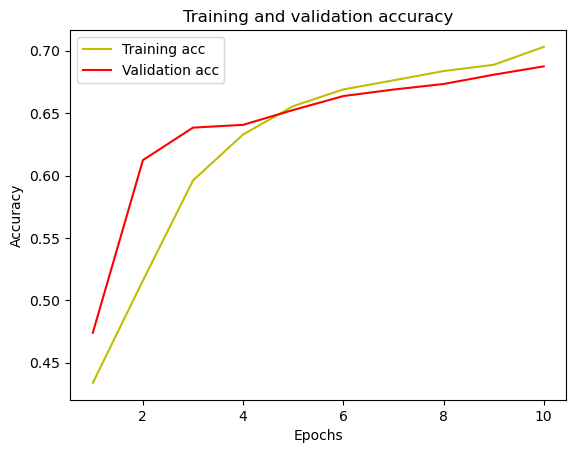

In [90]:
#ploting the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs,acc,'y',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [91]:
# Evaluating the model
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Loss:",np.round(test_loss,4))
print("Test Accuracy:", np.round(test_accuracy,4))

53/53 [==============================] - 0s 1ms/step - loss: 0.6971 - accuracy: 0.6939
Test Loss: 0.6971
Test Accuracy: 0.6939


In [92]:
test_data = pad_sequences(test_data, maxlen=20)
# Model Prediction
predictions = model.predict(test_data)

53/53 [==============================] - 0s 569us/step


In [93]:
predicted_labels = np.argmax(predictions, axis=1)

In [94]:
# Calculating precision, recall, f1-score, and support for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predicted_labels, average="macro")

print("Accuracy:",np.round(test_loss,4)*100,'%')
print("Precision:", np.round(precision,4))
print("Recall:", np.round(recall,4))
print("F1-score:", np.round(f1_score,4))

Accuracy: 69.71000000000001 %
Precision: 0.7281
Recall: 0.6513
F1-score: 0.6677


# LSTM

In [ ]:
#model architecture

model = keras.Sequential([
    keras.layers.Embedding(input_dim=100, output_dim=16, input_length=20),
    keras.layers.LSTM(units=32, return_sequences=True),
    keras.layers.LSTM(units=64),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dense(units=3, activation='softmax')
])


# Training

In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(train_data, train_labels, epochs=10, verbose=1, batch_size=64, validation_data=(val_data, val_labels))

In [ ]:
# Plotting the training and validation accuracy and loss at each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluating the model
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Loss:", np.round(test_loss, 4))
print("Test Accuracy:", np.round(test_accuracy, 4))

In [ ]:
# Making predictions
predicted_labels = model.predict(test_data)
predicted_labels = np.argmax(predicted_labels, axis=1)

In [ ]:
# Calculating precision, recall, f1-score, and support for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predicted_labels, average="macro")

print("Accuracy:", np.round(test_loss, 4) * 100, '%')
print("Precision:", np.round(precision, 4))
print("Recall:", np.round(recall, 4))
print("F1-score:", np.round(f1_score, 4))